In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(42)
random.seed(42)

# Загрузка данных

In [27]:
data = pd.read_csv('house/train.csv')

data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


# Проверка на пропущенные значения

In [28]:
missing_values = data.isnull().sum()
print("Пропущенные значения в данных:")
print(missing_values[missing_values > 0])

Пропущенные значения в данных:
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


# Разделение данных на признаки и целевую переменную

In [29]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение категориальных и числовых столбцов

In [30]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Создание pipeline для предобработки данных

In [31]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])


# Обьединение транформиров

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)


# Определение модели

In [33]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

In [34]:
X_train.shape

(1168, 80)

# Гиперпараметрический поиск

In [35]:
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [2, 3, 4],
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'regressor__subsample': [0.4, 0.5, 0.6, 0.8],
    'regressor__colsample_bytree': [0.2, 0.3, 0.4, 0.6, 0.8],
    'regressor__gamma': [0.1, 0.2, 0.3],
    'regressor__reg_alpha': [0, 0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, ],
    'regressor__reg_lambda': [0.1, 0.2, 0.5, 1, 1.5, 2, ]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=150,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

Определяем лучшие параметры для модели

In [36]:
random_search.fit(X_train, y_train)

# Результат
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Fitting 4 folds for each of 150 candidates, totalling 600 fits
Best parameters found: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 2, 'regressor__reg_alpha': 2, 'regressor__n_estimators': 300, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.2}
Best score: -871437024.0452491


# Оценка модели

In [37]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 15472.795242936643
RMSE: 124.38969106375593


# Построение кривой обучения

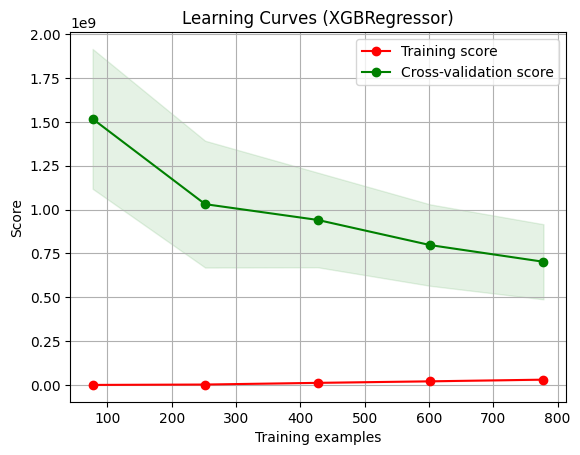

In [38]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Построение кривой обучения для лучшей модели
plot_learning_curve(best_model, "Learning Curves (XGBRegressor)", X_train, y_train, cv=3, n_jobs=-1)
plt.show()

# Сохранение модели

In [39]:
import pickle 

model_path = 'xgb_models/xgb_sandbox.pkl'
# Сохранение модели в файл 
with open(model_path, 'wb') as file:
    pickle.dump(best_model, file) 
 
# Загрузка модели из файла (для проверки)
with open(model_path, 'rb') as file: 
    loaded_model = pickle.load(file) 
 
# Проверка загруженной модели 
y_pred = loaded_model.predict(X_test) 
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 15472.795242936643
